In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# load SBML model
modelfile = os.getcwd()+'/models/240226MC_FULL.sbml'
r = te.loadSBMLModel(modelfile)

In [3]:
# get data and metadata for experiment
with open('data/230623_Kinetics_DA/simulation_ready.pkl', 'rb') as f:
    simulation_ready = pickle.load(f)
    init_concentrations = simulation_ready['init_concentrations']   
    metadata = simulation_ready['metadata']
    measurements = simulation_ready['measurements']

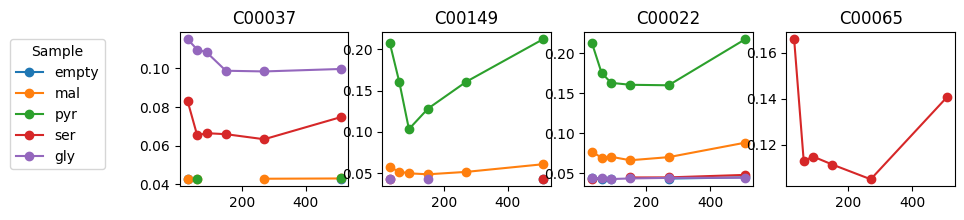

In [4]:
plt.figure(figsize=(10,2))
for s in metadata['sample_labels']:
    metadata['timepoints'][s] = metadata['timepoints'][s] + 30*60
    for i,m in enumerate(metadata['measurement_labels']):
        measurements[s][:,i] = measurements[s][:,i]#*1000*3.6
        plt.subplot(1,4,i+1)
        plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
        plt.title(m)
plt.legend(metadata['sample_labels'],bbox_to_anchor=(-4.65, 1), loc='upper left', title='Sample')

In [5]:
# get all the parameters that can vary during the fitting
kinetics_labels = [p for p in r.getGlobalParameterIds() if np.any([k in p for k in ['Km','Kcat','Ki']])]
Gi_labels = [p for p in r.getGlobalParameterIds() if 'Gi' in p ]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+150:sbml.find('<initialAssignment symbol="'+s+'">')+156]).split(' ')[0] for s in metabolites]

parameter_labels = kinetics_labels + Gi_labels + metabolites_labels # + list(metabolites_labels)
parameter_labels.append('rel0') # what are good bounds for this?

# make upper and lower bounds
upper = np.array([r[i]*10 for i in kinetics_labels] + [1 for _ in Gi_labels] + [10 for _ in metabolites_labels] + [10])
lower = np.array([r[i]/10 for i in kinetics_labels] + [1/100 for _ in Gi_labels] + [1/10 for _ in metabolites_labels] + [1/10])
p_initial = np.array([r[i] for i in kinetics_labels] + [0.3 for _ in Gi_labels] + [1 for _ in metabolites_labels] + [1])

# define variables that don't change during fitting, but could be different across samples
# (dilution factor, biosynthesis metabolites, which enzymes are present)
variables = {}
for s in metadata['sample_labels']:
    variables[s] = {'dilution_factor':1/metadata['dilution_factor'][s]}
    variables[s] = {**variables[s] , **{p:1 for p in r.getGlobalParameterIds() if 'p_EC' in p}}
    variables[s] = {**variables[s] , **init_concentrations[s]}


In [6]:
# train-test split across conditions
from copy import deepcopy
all_models = [modelfile]*2
all_data = [deepcopy(measurements) for _ in range(2)]
all_metadata = [deepcopy(metadata) for _ in range(2)]
all_variables = [deepcopy(variables) for _ in range(2)]

test_on = [['empty','pyr'],['empty','pyr']]

def train_test_split(models, data, metadata, variables, test_on):
    test = {'data':[{} for _ in range(len(test_on))], 
            'metadata':[{} for _ in range(len(test_on))], 
            'variables':[{} for _ in range(len(test_on))],
            'models':models}
    for i, exp in enumerate(test_on):
        for sample in exp:
            test['data'][i][sample] = data[i].pop(sample)
            test['variables'][i][sample] = variables[i].pop(sample)
        test['metadata'][i] = deepcopy(metadata[i])
        test['metadata'][i]['sample_labels'] = exp
        metadata[i]['sample_labels'] = [s for s in metadata[i]['sample_labels'] if s not in exp]

    train = {'data':data, 'metadata':metadata, 'variables':variables, 'models':models}
    return train, test

train, test = train_test_split(all_models, all_data, all_metadata, all_variables, test_on)

In [7]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
train_myprob,test_myprob = [SBMLGlobalFit_Multi_Fly(
    model = t['models'], 
    data = t['data'], 
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=t['metadata'],
    variables=t['variables'],
    scale=True) for t in [train, test]]

train_prob = pg.problem(train_myprob)
test_prob = pg.problem(test_myprob)

In [8]:
import ipyparallel as ipp
from src.fitting.pygmo_bfes import pickleless_bfe

client = ipp.Client(profile='cheme-ecfers')
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/dalba/repos/ECFERS');

def set_affinity_on_worker():
    """When a new worker process is created, the affinity is set to all CPUs"""
    import os
    os.system("taskset -p 0xffffffffff %d" % os.getpid())

client[:].apply_sync(set_affinity_on_worker)

udbfe = pickleless_bfe(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs = {}, temp_dv_path = os.getcwd()+'/models/binaries', prob = {'train':train_prob,'test':test_prob})
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'},view_kwargs = {})
mybfe = pg.bfe(udbfe)

In [9]:
# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
replicates = 1
for i in range(replicates):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.01, variant=5, neighb_type=2, neighb_param=4)
    # a = pg.gaco(gen=10)
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    pops.append(pg.population(train_prob, size = 0))

In [17]:
total_nodes = len(client[:])*10

for p in pops:
    xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p/1.5,p*1.5, total_nodes)) for p in p_initial])).T
    fs = udbfe(train_prob,xs.reshape(-1))
    list(map(p.push_back, xs, fs[:,np.newaxis]))

with open('checkpoint_t.dat', 'wb') as file:
    pickle.dump(pops, file)

In [10]:
import pickle

with open('logs_t.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

with open('checkpoint_t.dat', 'rb') as file:
    pops = pickle.load(file)

In [20]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
logs = [[] for _ in range(replicates)]
test_fit = []
for i in range(100):
    print(now() + ' - Starting evolution ' + str(i))
    pops = [a.evolve(p) for a,p in zip(algos,pops)]
    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))
    
    test_fit.append([[udbfe(test_prob,p.get_x().reshape(-1), mode = 'test')] for p in pops])

    for i,a in enumerate(algos):
        logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))

    with open('logs_t.dat', 'wb') as file:
        pickle.dump([logs,test_fit], file)

    with open('checkpoint_t.dat', 'wb') as file:
        pickle.dump(pops, file)

    # if np.min([p.champion_f for p in pops]) < prob.extract(SBMLGlobalFit)._residual(result[:,1:].__array__()*(1.055),result[:,1:].__array__()):
    #     break
    

20-05-2024, 12:38:10 - Starting evolution 0


NameError: name 'total_nodes' is not defined

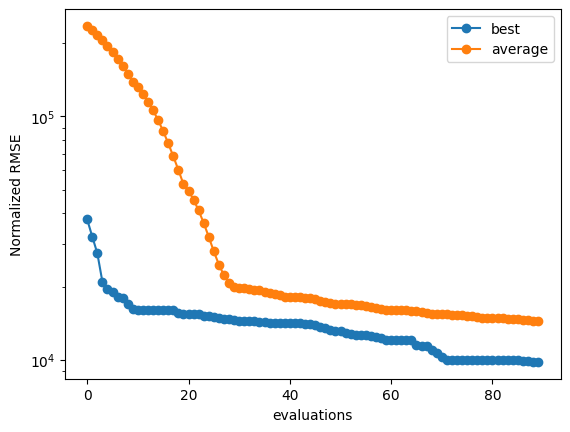

In [16]:
results = [np.concatenate(l,axis=0) for l in logs]
[plt.plot(res[:,2],'o-') for res in results]
[plt.plot(res[:,4],'o-') for res in results]
plt.legend(['best','average'])
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Normalized RMSE')
plt.xlabel('evaluations')
plt.title('Convergence curve (n=1; p='+str(total_nodes)+') for fitting METABOLISM')  

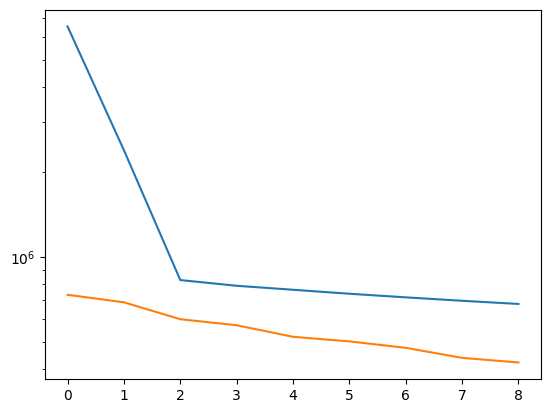

In [12]:
plt.plot(np.squeeze(np.array(test_fit)).mean(axis=1))
plt.plot(np.squeeze(np.array(test_fit)).min(axis=1))
plt.yscale('log')

In [14]:
myprob._setup_rr()

all_results = [{s:[] for s in m['sample_labels']} for m in myprob.metadata] 
for k,c in enumerate(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:15],:]):
    res = myprob._simulate(myprob._unscale(c))
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results, res, myprob.metadata, myprob.model_stuff)]


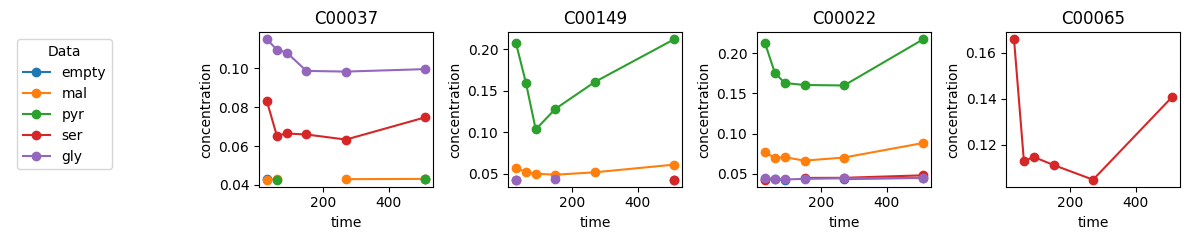

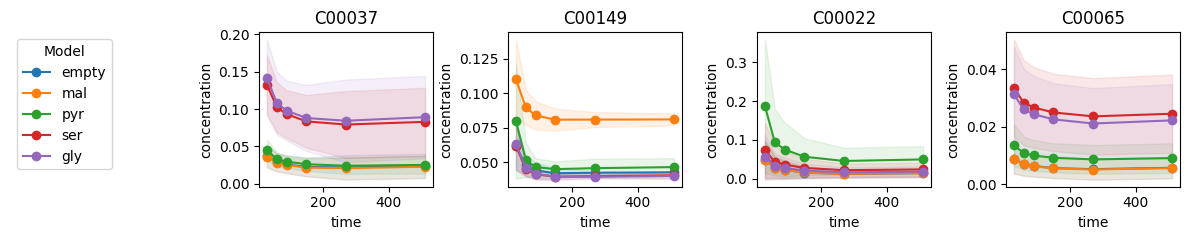

In [13]:
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Data')
plt.gca().axis('off')
plt.tight_layout()
    
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results[s],0)[:,i]
        std = np.std(all_results[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()
    

In [9]:
top_pop = pg.population(pg.problem(myprob), size = 0)
list(map(top_pop.push_back, pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:600],:],pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:600],:]));

In [10]:
top_pop = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:600],:]

In [11]:
def multi_minimize(pop, prob, rank):
    from scipy.optimize import minimize, Bounds 
    bounds = Bounds(prob.get_bounds()[0],prob.get_bounds()[1],True)
    options = {'maxfev':2500,'adaptive':True}
    results = minimize(prob.fitness, pop[rank,:], method='Nelder-Mead', bounds = bounds, options = options)
    return results

In [12]:
udbfe._view.push({"multi_minimize": multi_minimize,"pop":top_pop}, block = True);

In [13]:
local_fits = udbfe._view.apply_sync(lambda x,y,z: multi_minimize(x,y,z), ipp.Reference("pop"), ipp.Reference("prob"), ipp.Reference("rank"))

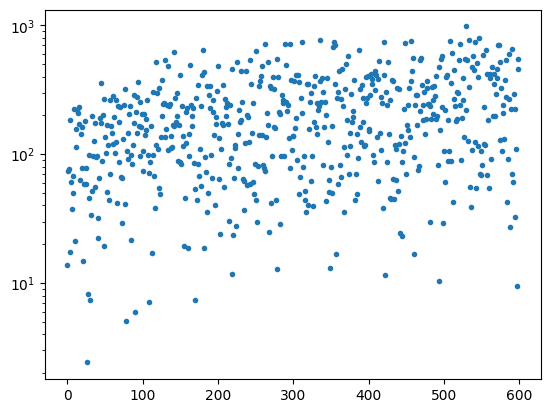

In [46]:
plt.plot(np.squeeze(pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:600],:]) - [fit.fun for fit in local_fits],'.')
plt.yscale('log')

In [38]:
print(np.arange(15))
print(np.argsort([fit.fun for fit in local_fits])[:15])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 4  9  0  1  2 16 13 14  5  3 45  7 12  6 15]


In [40]:
np.argsort([fit.fun for fit in local_fits])[:15]
local_fits[0].x

array([0.00115716, 0.0521422 , 0.06525401, ..., 0.16534265, 0.24093261,
       0.12788583])

In [42]:
myprob._setup_rr()
all_results_local = {s:[] for s in metadata['sample_labels']}
for k,c in enumerate(np.argsort([fit.fun for fit in local_fits])[:15]):
    res_dict = myprob._simulate(myprob._unscale(local_fits[c].x))
    [all_results_local[s].append(res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]) for s in metadata['sample_labels']]

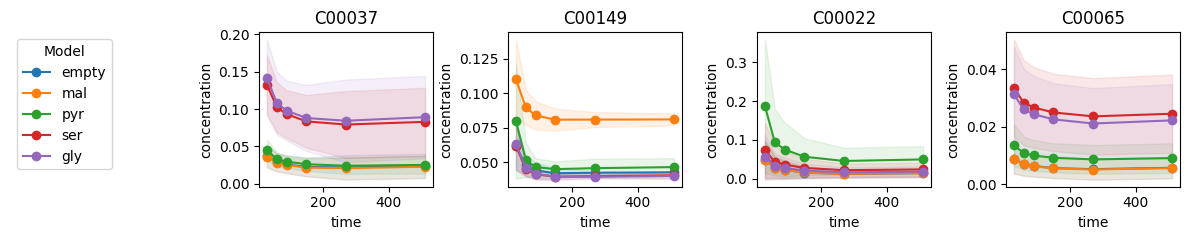

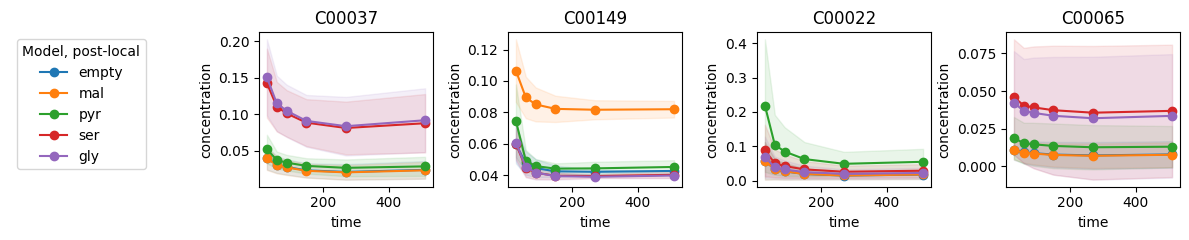

In [47]:
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results[s],0)[:,i]
        std = np.std(all_results[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()

plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results_local[s],0)[:,i]
        std = np.std(all_results_local[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model, post-local')
plt.gca().axis('off')
plt.tight_layout()